<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_OLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta


# **Loading data from drive, doing feature selection/transformation**

In [3]:
#importing libs for the model
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# #independent variables

x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')

# x.columns=x.iloc[0,:]

x.index=x['Date']
x.drop(columns=['Date'], inplace=True)
# x['Mortgage loans'] = np.log(x['Mortgage loans'])
x['Mortgage loans']=np.log(x['Mortgage loans'])

In [5]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

In [6]:
len(x.columns.values)


66

##List of factors with growth rate

In [7]:

to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


##Definin factors to remove/combine

In [8]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)

x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)


In [9]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [10]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

# # x.columns=x.iloc[0,:]

y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


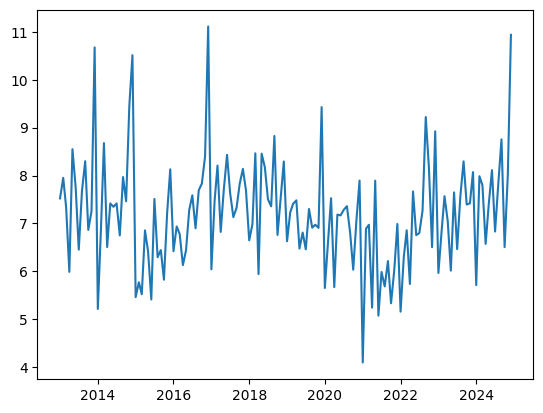

In [11]:
plt.plot(y)

In [12]:
x_back=x.copy(deep=True)

In [13]:
y_back=y.copy(deep=True)

In [14]:
# factors=a[a['close'].isnull()==False]
# factors

## **Stationarity adjustments**


In [15]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))


In [16]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [17]:
#x.info()

In [18]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    x[i].fillna(0, inplace = True)
    dict_normalized[i]=check_stationarity(x[i])[2]
    #print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
# dict_normalized

<ipython-input-18-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[i].fillna(0, inplace = True)
<ipython-input-18-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col:

In [19]:
print(len(features))
print(len(levels))
# pd.DataFrame({"name":features, "diff_level":levels})

44
44


In [20]:
type(dict_normalized.std().values)

numpy.ndarray

In [21]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})
denormdf.sort_values(by='diff_level', ascending=False)



,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
16,Return on capital,1
41,Dolarisation_avg,1
38,Transport and communications loans (fc),1
37,Others loans,1
36,Mortgage loans,1


In [22]:
# stationarity['stdev']=dict_normalized.std().values
# stationarity

In [23]:
#stationarity.to_csv('/content/drive/My Drive/Dissertation/levels_stdevs.csv')

In [24]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=7]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>7]
valid_factors

,factor
0,Inflow (trade)
1,Inflow (non-trade)
2,Outflow (trade)
3,Outflow (non-trade)
4,Reserve position in the IMF
5,Foreign Exchange Reserves
6,Government’s net domestic assets (million AMD)
7,Banks’ net domestic assets (million AMD)
8,Net other assets (million AMD)
9,CPI


In [25]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


In [26]:
#defining X and Y

In [27]:
x=dict_normalized
x=x[valid_factors]

In [28]:
#x

In [29]:
y=pd.DataFrame({'Z-score':y})
#y

##**Creating scaled factors**

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled= scaler.fit_transform(x)


In [31]:
X=pd.DataFrame(x_scaled, columns=x.columns.values)
X.index=x.index

# **Model evaluation  with lagged  variables**

## **Creating lagged variables**

In [32]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from scipy.stats import shapiro
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [33]:
y.index=X.index
z_s=pd.concat([X,y], axis=1)
z=pd.concat([x,y], axis=1)
z.astype(float)


,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans,Z-score
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,0.016509,-8.361170e-04,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361,7.521965
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,0.007990,-3.522740e-05,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111,0.429852
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,0.040489,1.274980e-03,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163,-0.614530
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,0.022991,3.834620e-04,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804,-1.349483
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,0.015826,-3.168855e-06,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148,2.562559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,0.023861,3.354004e-04,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544,0.994868
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,0.025566,-4.624434e-07,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969,0.930966
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,0.024482,4.086000e-04,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043,-2.251795


In [34]:
z.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [35]:

#creating lags of the model
lag_1=z.shift(1)
lag_1_cols=[i+'_L1' for i in lag_1.columns.values]
lag_1.columns=lag_1_cols

lag_2=z.shift(2)
lag_2_cols=[i+'_L2' for i in lag_2.columns.values]
lag_2.columns=lag_2_cols


lag_3=z.shift(3)
lag_3_cols=[i+'_L3' for i in lag_3.columns.values]
lag_3.columns=lag_3_cols


lag_4=z.shift(4)
lag_4_cols=[i+'_L4' for i in lag_4.columns.values]
lag_4.columns=lag_4_cols


lag_5=z.shift(5)
lag_5_cols=[i+'_L5' for i in lag_5.columns.values]
lag_5.columns=lag_5_cols



lag_6=z.shift(6)
lag_6_cols=[i+'_L6' for i in lag_6.columns.values]
lag_6.columns=lag_6_cols

In [36]:
#As z is not the scaled one, all and lagged is also not scaled

In [37]:
all_and_lagged=pd.concat([z,lag_1,lag_2, lag_3, lag_4, lag_5,lag_6],axis=1)
all_and_lagged.columns.values
# all_and_lagged=all_and_lagged[all_and_lagged['avg ekamtaberutyun_L2'].isnull()==False]
#not stationary


array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [38]:
print(all_and_lagged.isnull().sum().values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [39]:
all_and_lagged.dropna(inplace=True)

In [40]:
len(all_and_lagged.columns.values)

315

In [41]:
all_and_lagged=all_and_lagged.astype(float)

In [42]:
len(all_and_lagged.columns.values)

315

In [43]:

y_l=all_and_lagged['Z-score']
x_l=all_and_lagged.drop('Z-score', axis=1)


In [44]:
#we scale only x_ls, so x_ls is the only scaled factor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_ls_scaled= scaler.fit_transform(x_l)

In [45]:
x_ls_scaled

array([[ 5.52164871e-02,  1.57100029e+00,  1.17651570e-01, ...,
         7.34902765e+00,  1.09251224e+01,  4.51738434e+00],
       [-3.03709597e-01, -2.82102536e-01, -5.52684975e-02, ...,
         7.07010164e+00,  1.83957061e-01,  2.24604778e-01],
       [-1.24449972e-01, -6.43311767e-01,  5.13195402e-04, ...,
        -1.32887387e-01, -4.62892382e-01, -4.07548441e-01],
       ...,
       [ 2.33070364e+00, -6.89277818e-02,  1.51548933e+00, ...,
        -3.52394766e-01, -3.31730295e-01, -7.77790921e-01],
       [-1.50256190e+00, -1.53966725e-01, -3.68296235e-01, ...,
        -1.02225781e-01,  1.78385020e-01,  4.65233741e-01],
       [ 5.96268788e+00,  9.93122041e-01,  1.90833330e+00, ...,
        -2.73793327e-01,  3.69753533e-01,  3.95598766e-01]])

In [46]:

x_ls_scaled=pd.DataFrame(x_ls_scaled, columns=x_l.columns.values)
x_ls_scaled.index=x_l.index

In [47]:
# x_ls=sm.add_constant(x_ls_scaled)
x_ls=x_ls_scaled

## **Applying ridge and lasso regressions**

In [48]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
# Create and fit the Group Lasso model
# Define a range of alpha values in log space
alphas = np.logspace(-4, 1, 50)  # From 0.0001 to 10

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential splits

# Fit LassoCV with time-aware CV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=43).fit(x_ls, y_l)

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)
lasso_coefs = lasso_cv.coef_


# Best alpha value
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.11513953993264481
Best alpha: 0.11513953993264481


In [49]:
from decimal import Decimal
lasso_eval_l=pd.DataFrame({"var_name": x_ls.columns.values, "lasso_coef":lasso_coefs})

#CV=4
lasso_remove_l=lasso_eval_l['var_name'][lasso_eval_l['lasso_coef']==0].values
lasso_remove_l
lasso_eval_l['lasso_coef']=lasso_eval_l['lasso_coef'].apply(lambda i: Decimal(i) )

In [50]:
print(len(lasso_eval_l))
print(len(lasso_remove_l))

314
290


In [52]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from decimal import Decimal

# Define a range of alpha values
alphas = np.logspace(-4, 4, 50)  # Test alphas from 0.0001 to 10,000

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential training-test splits

# RidgeCV with time-series-aware CV
ridge_cv = RidgeCV(alphas=alphas, scoring='r2', store_cv_values=True)
ridge_cv.fit(x_ls, y_l)

# Get the best alpha
best_alpha = ridge_cv.alpha_
print("Best Alpha:", best_alpha)

# Fit the final Ridge model using the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_ls, y_l)

# Model evaluation
score = ridge_best.score(x_ls, y_l)
print("R-squared:", score)

# Inspect the coefficients
ridge_coef = ridge_best.coef_
ridge_df_2 = pd.DataFrame({'factors': x_ls.columns.values, 'score': [Decimal(i) for i in ridge_coef] })
print(ridge_df_2)
print(ridge_best.coef_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best Alpha: 0.0001
R-squared: 0.9999999999996534
                         factors  \
0                 Inflow (trade)   
1             Inflow (non-trade)   
2                Outflow (trade)   
3            Outflow (non-trade)   
4    Reserve position in the IMF   
..                           ...   
309             bitcoin_price_L6   
310          Dolarisation_avg_L6   
311          Gov. bond yealds_L6   
312                  fc-loans_L6   
313                   Z-score_L6   

                                                 score  
0    0.07661898660062925470182193521395674906671047...  
1    0.13625652030426066430024434339429717510938644...  
2    0.03386620818924148540451923850014281924813985...  
3    0.11952832044758730789535405847345828078687191...  
4    -0.0247013757031228908811471001172321848571300...  
..                                                 ...  
309  -0.0138556064974708001424907877208170248195528...  
310  -0.0831628375768251465460778604210645426064729...  
311  

In [53]:
len(x_ls.columns.values)


314

In [54]:
ridge_df_2.sort_values(by='score')
ridge_significant_l=ridge_df_2[abs(ridge_df_2['score'])>0.05]
ridge_insignificant_l=ridge_df_2[abs(ridge_df_2['score'])<=0.05]
#0.001 is good


In [55]:
print(len(ridge_df_2))
print(len(ridge_insignificant_l))

314
220


In [56]:
# ridge_significant_l

In [57]:
corr=pd.concat([x_ls,y_l],axis=1).corr()
y_corr_l=corr[['Z-score']].iloc[1:]


In [58]:
len(y_corr_l)

314

In [59]:
y_corr_l

,Z-score
Inflow (non-trade),0.519187
Outflow (trade),0.150304
Outflow (non-trade),0.446911
Reserve position in the IMF,-0.056575
Foreign Exchange Reserves,0.437214
...,...
Dolarisation_avg_L6,-0.125576
Gov. bond yealds_L6,-0.008538
fc-loans_L6,-0.055646
Z-score_L6,0.102572


In [60]:
l1=[i for i in lasso_remove_l]
l2=[i for i in ridge_insignificant_l['factors'].values]

# # Step 4: Convert the DataFrame back into a single list
combined_list = l1 + l2

# Step 3: Convert the combined list to a set to remove duplicates
to_remove_l = list(set(combined_list))
len(to_remove_l)

293

In [61]:
to_remove_l

['CPI_L3',
 'CPI-Services_L1',
 'Time deposits in AMD (million AMD)_L3',
 'Normative capital ratio to risk-weighted assets',
 'Outflow (non-trade)_L5',
 'Foreign Exchange Reserves_L5',
 'Agriculture loans_L1',
 'Government’s net domestic assets (million AMD)',
 'bitcoin_price_L6',
 'US Dollar/AMD_L6',
 'Others loans_L3',
 'Gov. bond yealds_L3',
 'Total capital (million AMD)_L1',
 'Economic activity index_L3',
 'Trade loans_L4',
 'Gov. bond yealds_L4',
 'Industry Loans_L2',
 'Transport and communications loans (fc)_L3',
 'High liquidity assets ratio to demand liabilities_L6',
 'Consumer loans loans_L4',
 'Inflow (non-trade)_L1',
 'Z-score_L4',
 'Cash in circulation (million AMD)_L2',
 'Total capital (million AMD)_L6',
 'Consumer loans loans_L5',
 'Transport and communications loans (fc)_L1',
 'Z-score_L5',
 'Mortgage loans_L6',
 'Demand deposits in AMD (million AMD)_L1',
 'Consumer loans loans_L2',
 'Mortgage loans_L3',
 'Russian Ruble/AMD_L6',
 'Outflow (trade)_L2',
 'CPI_L1',
 'Russia

In [62]:
#we remove factors needed to be removed from x
#const is also removed, so we need to add constant again
x_l=x_l[[i for i in x_ls.columns.values if i not in to_remove_l]]

In [63]:
len(x_l.columns.values)

21

In [64]:
df=pd.DataFrame(x_l.columns.values, columns=['factors'])
df

,factors
0,Inflow (non-trade)
1,Outflow (non-trade)
2,Foreign Exchange Reserves
3,Banks’ net domestic assets (million AMD)
4,Demand deposits in AMD (million AMD)
5,Foreign currency deposits (million AMD)
6,Gov. bond yealds
7,fc-loans
8,Inflow (trade)_L1
9,Banks’ net domestic assets (million AMD)_L1


In [65]:
X_l_train, X_l_test, Y_l_train, Y_l_test = train_test_split(x_l, y_l, test_size=0.1, random_state=0, shuffle=False)
# Create and train the linear regression model


In [66]:
mean_train_X = X_l_train.mean()
std_train_X = X_l_train.std()

# Standardize X (each feature separately)
X_train_scaled = (X_l_train - mean_train_X) / std_train_X
X_test_scaled = (X_l_test - mean_train_X) / std_train_X  # Use train's mean & std



In [67]:

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled  = sm.add_constant(X_test_scaled)


In [68]:
len(X_train_scaled.columns.values)

22

In [69]:
X_l_train=X_l_train.astype(float)

In [70]:
len(X_l_train.columns.values)

21

In [71]:
#GLS adjusts for autocorrelation, improving coefficient estimates.
import statsmodels.api as sm

model = sm.OLS(Y_l_train, X_train_scaled).fit()
#model = sm.OLS(Y_l_train, X_l_train).fit()

# Get the summary of the model
summary = model.summary()

# Print the summary
print(summary)
# Make predictions

                            OLS Regression Results                            
Dep. Variable:                Z-score   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     44.74
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           4.88e-42
Time:                        20:52:27   Log-Likelihood:                -86.060
No. Observations:                 124   AIC:                             216.1
Df Residuals:                     102   BIC:                             278.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

##**Evaluating lagged ols model performance**

In [72]:
params=pd.DataFrame({"model_coefs":model.params})
params['p-values']=model.pvalues

In [73]:
f=params[params['p-values']<=0.05].sort_values(by='model_coefs', ascending=False)
f

,model_coefs,p-values
Banks’ net domestic assets (million AMD),0.334636,4.299238e-07
Inflow (non-trade),0.300512,5.903939e-05
Foreign currency deposits (million AMD),0.271523,3.608424e-05
Demand deposits in AMD (million AMD),0.233593,9.417361e-04
Foreign Exchange Reserves,0.206967,5.798616e-04
Inflow (non-trade)_L5,0.175173,3.364186e-03
Industry Loans_L3,0.175030,8.746976e-04
fc-loans,0.136015,2.790405e-02
Banks’ net domestic assets (million AMD)_L1,-0.135813,4.185408e-02
Inflow (trade)_L1,-0.143890,1.611790e-02


In [74]:
Y_l_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(Y_l_test, Y_l_pred)
r2 = r2_score(Y_l_test, Y_l_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.12976156788429477
R^2 Score: 0.9439690653993988


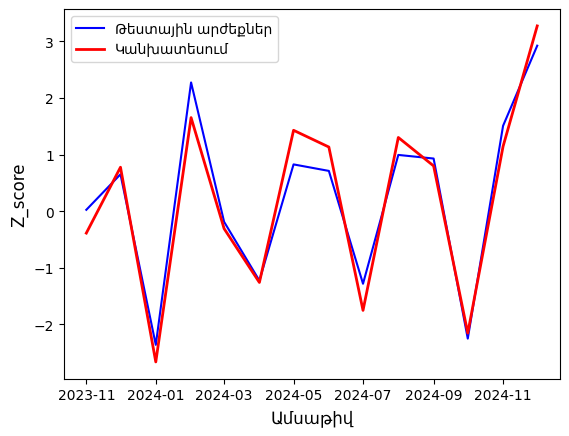

In [75]:
plt.plot(Y_l_test, color='blue', label='Թեստային արժեքներ')
plt.plot(Y_l_pred, color='red', linewidth=2, label='Կանխատեսում')
plt.xlabel('Ամսաթիվ', fontsize=12)
plt.ylabel('Z_score',fontsize=12)
plt.legend()
plt.show()

In [76]:
len(X_l_test)

14

In [77]:
train_pred=model.predict(X_test_scaled)
mse = mean_squared_error(Y_l_test, train_pred)
r2 = r2_score(Y_l_test, train_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.12976156788429477
R^2 Score: 0.9439690653993988


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(Y_l_test, train_pred)
mse = mean_squared_error(Y_l_test, train_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_l_test, train_pred)
print('Forecast Accuracy Metrics:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
# Interpretation:

Forecast Accuracy Metrics:
MAE: 0.31121441459375176
MSE: 0.12976156788429477
RMSE: 0.3602243299449591
MAPE: 1.4517891707614845


In [79]:
# Durbin-Watson test for independence of errors
dw = durbin_watson(model.resid)
print('Durbin-Watson:', dw)
#dw is 2.5 some level of negative autocorrelation in the residuals of your regression model

Durbin-Watson: 2.1682363883699756


In [80]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
#there is no heterosketasticity in the model


{'Lagrange multiplier statistic': 19.408380295742223, 'p-value': 0.558960629679006, 'f-value': 0.9013081161639082, 'f p-value': 0.5897243667946457}


In [81]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming `residuals` is the array of residuals from your model
ljung_box_result = acorr_ljungbox(model.resid, lags=[1,2,3,4,5])
ljung_box_result

,lb_stat,lb_pvalue
1,0.914842,0.338833
2,1.139259,0.565735
3,3.504820,0.320138
4,3.504948,0.477126
5,4.716054,0.451506


In [82]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Assuming `model` is your fitted OLS regression model
breusch_godfrey_result = acorr_breusch_godfrey(model, nlags=6)
print(breusch_godfrey_result)
#If p < 0.05, reject 𝐻0H 0  → Residuals are autocorrelated.

(6.9693190658761335, 0.3236938851591632, 0.95281941593407, 0.4614466324159665)


In [83]:
# Shapiro-Wilk test for normality of residuals
shapiro_test = shapiro(model.resid)
print('Shapiro-Wilk test:', shapiro_test)
#this test is not concrete: in one case, w stats is close to one, which indicates positive autocorrelation, on the other hand, pvalue <0.05 suggests evidence of autocorrelation

Shapiro-Wilk test: ShapiroResult(statistic=0.9868611836668547, pvalue=0.2780546468260233)


In [84]:
ad_test = normal_ad(model.resid)
print('Anderson-Darling test:', ad_test)

Anderson-Darling test: (0.4155364329747755, 0.32868948186025293)


In [85]:
coefficients = model.params
p_values = model.pvalues

# Combining coefficients and p-values into a DataFrame for better display
results_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-value': p_values
})

print(results_df)

                                                   Coefficient       P-value
const                                                -0.002900  9.518984e-01
Inflow (non-trade)                                    0.300512  5.903939e-05
Outflow (non-trade)                                  -0.004327  9.543920e-01
Foreign Exchange Reserves                             0.206967  5.798616e-04
Banks’ net domestic assets (million AMD)              0.334636  4.299238e-07
Demand deposits in AMD (million AMD)                  0.233593  9.417361e-04
Foreign currency deposits (million AMD)               0.271523  3.608424e-05
Gov. bond yealds                                     -0.087989  2.431107e-01
fc-loans                                              0.136015  2.790405e-02
Inflow (trade)_L1                                    -0.143890  1.611790e-02
Banks’ net domestic assets (million AMD)_L1          -0.135813  4.185408e-02
Euro/AMD_L1                                          -0.204141  5.723301e-04

In [86]:
results_df[results_df['P-value']<=0.05].sort_values(by='Coefficient', ascending=False)

,Coefficient,P-value
Banks’ net domestic assets (million AMD),0.334636,4.299238e-07
Inflow (non-trade),0.300512,5.903939e-05
Foreign currency deposits (million AMD),0.271523,3.608424e-05
Demand deposits in AMD (million AMD),0.233593,9.417361e-04
Foreign Exchange Reserves,0.206967,5.798616e-04
Inflow (non-trade)_L5,0.175173,3.364186e-03
Industry Loans_L3,0.175030,8.746976e-04
fc-loans,0.136015,2.790405e-02
Banks’ net domestic assets (million AMD)_L1,-0.135813,4.185408e-02
Inflow (trade)_L1,-0.143890,1.611790e-02


#**Finish**